The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:

In [1]:
%pylab inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.pyplot import imread
# import imageio
from matplotlib import image


from sklearn.metrics import accuracy_score

# import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Convolution2D, Flatten, MaxPooling2D, Reshape, InputLayer
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.preprocessing.image import load_img

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = '/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/'
os.listdir(path)

['icml_face_data.csv',
 'fer2013.tar.gz',
 'example_submission.csv',
 'train.csv',
 'test.csv']

In [3]:
data = pd.read_csv(path+'icml_face_data.csv')

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


 Define training, validation and test data:

In [5]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

Now we will be using Image Augmentation techniques om our dataset.

In [6]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the images:

In [7]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
X_train = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
X_val = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
X_test = test_images.astype('float32')/255

Encoding of the target value:

In [8]:
y_train = keras.utils.to_categorical(train_image_label)
y_val = keras.utils.to_categorical(val_image_label)
y_test = keras.utils.to_categorical(test_image_label)
#keras.utils.to_categorical(train['label'].values)

In [9]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
28704,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28705,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28706,0.0,0.0,0.0,0.0,1.0,0.0,0.0
28707,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Augmentation

In [10]:
# With data augmentation to prevent overfitting
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Now Using CNN Model:

In [11]:
# define vars
input_reshape = (48, 48, 1)

pool_size = (2, 2)

hidden_num_units = 265
output_num_units = 7

epochs = 10
batch_size = 128

In [12]:
%time



model = Sequential([

Convolution2D(75,(2,2), activation='relu',input_shape=input_reshape),
MaxPooling2D((2,2)),

Convolution2D(50,(2,2), activation='relu'),
MaxPooling2D((2,2)),

Convolution2D(25,(2,2), activation='relu'),

Flatten(),

Dense(hidden_num_units, 'relu'),

Dense(output_num_units,'softmax'),
 ])


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 75)        375       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 50)        15050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 25)        5025      
_________________________________________________________________
flatten (Flatten)            (None, 2500)              0         
_________________________________________________________________
dense (Dense)                (None, 265)               6

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_conv = model.fit(X_train, y_train, epochs =epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
225/225 [==============================] - 2s 10ms/step - loss: 1.6862 - accuracy: 0.3291 - val_loss: 1.5660 - val_accuracy: 0.4087
Epoch 2/10
225/225 [==============================] - 2s 9ms/step - loss: 1.4982 - accuracy: 0.4235 - val_loss: 1.4395 - val_accuracy: 0.4486
Epoch 3/10
225/225 [==============================] - 2s 9ms/step - loss: 1.3745 - accuracy: 0.4751 - val_loss: 1.3671 - val_accuracy: 0.4773
Epoch 4/10
225/225 [==============================] - 2s 9ms/step - loss: 1.2890 - accuracy: 0.5084 - val_loss: 1.2968 - val_accuracy: 0.4912
Epoch 5/10
225/225 [==============================] - 2s 9ms/step - loss: 1.2155 - accuracy: 0.5404 - val_loss: 1.2775 - val_accuracy: 0.5082
Epoch 6/10
225/225 [==============================] - 2s 9ms/step - loss: 1.1519 - accuracy: 0.5668 - val_loss: 1.2409 - val_accuracy: 0.5219
Epoch 7/10
225/225 [==============================] - 2s 9ms/step - loss: 1.0918 - accuracy: 0.5927 - val_loss: 1.2570 - val_accuracy: 0.5277
Epoch

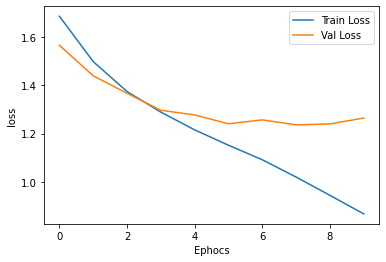

In [15]:
plt.plot(trained_model_conv.history['loss'],label='Train Loss')
plt.plot(trained_model_conv.history['val_loss'],label='Val Loss')
plt.xlabel('Ephocs')
plt.ylabel('loss')
plt.legend()
plt.show()

I have added 2 convolutional layers each followed by an activation and then Dropout technique. 20 ephocs 

In [16]:
model = Sequential()
#Block-1
model.add(Convolution2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-2
model.add(Convolution2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-3
model.add(Convolution2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-4
model.add(Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_reshape))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Convolution2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

#Block-5
model.add(Flatten())
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.3))

#Block-6
model.add(Dense(units = 7 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 256)       2560      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       590080    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)        

In [17]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Before compiling i will create 3 things using keras.callbacks class:

**1-Checkpoint( Function — ModelCheckpoint() )**

It will monitor the validation loss and will try to minimize the loss using the mode=’min’ property. When the checkpoint is reached it will save the best trained weights. Verbose=1 is just for visualization when the code created checkpoint.Here i am using it’s following parameters:

**file-path:** Path to save the model file.Here i am saving the model file with the name EmotionDetectionModel.h5
**monitor:** Quantity to monitor.Here i am monitoring the validation loss.

**mode:** One of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity.

**save_best_only:** If save_best_only=True, the latest best model according to the quantity monitored will not be overwritten.
**verbose:** int. 0: quiet, 1: update messages.

**2-Early Stopping ( Function — EarlyStopping() )**

This will stop the execution early by checking the following properties.

**monitor:** Quantity to monitor.Here i am monitoring the validation loss.

**min_delta:** Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than **min_delta,** will count as no improvement.Here i have given it 0.

**patience:** Number of epochs with no improvement after which training will be stopped. Here i have given it 3.

**restore_best_weights:** Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.Here i have given it True.

**verbose:** int. 0: quiet, 1: update messages.

**3-Reduce Learning Rate ( Function — ReduceLROnPlateau() )**

Models often benefit from reducing the learning rate by a factor of 2–10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced. I have used the following properties for this.

**monitor**: To monitor a particular loss. Here i am monitoring the validation loss.

**factor**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Here i am using 0.2 as factor.

**patience**: Number of epochs with no improvement after which learning rate will be reduced.Here i am using 3.

**min_delta**: Threshold for measuring the new optimum, to only focus on significant changes.

**verbose**: int. 0: quiet, 1: update messages.

In [18]:
checkpoint = ModelCheckpoint('EmotionDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

trained_model_conv = model.fit(X_train, y_train, epochs =20, batch_size=128,callbacks=callbacks, validation_data=(X_val, y_val))

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.8248 - accuracy: 0.2490
Epoch 00001: val_loss improved from inf to 1.81616, saving model to EmotionDetectionModel.h5
225/225 [==============================] - 8s 36ms/step - loss: 1.8248 - accuracy: 0.2490 - val_loss: 1.8162 - val_accuracy: 0.2449
Epoch 2/20
223/225 [============================>.] - ETA: 0s - loss: 1.8118 - accuracy: 0.2515
Epoch 00002: val_loss improved from 1.81616 to 1.81509, saving model to EmotionDetectionModel.h5
225/225 [==============================] - 8s 34ms/step - loss: 1.8122 - accuracy: 0.2513 - val_loss: 1.8151 - val_accuracy: 0.2449
Epoch 3/20
223/225 [============================>.] - ETA: 0s - loss: 1.8002 - accuracy: 0.2518
Epoch 00003: val_loss improved from 1.81509 to 1.78771, saving model to EmotionDetectionModel.h5
225/225 [==============================] - 8s 34ms/step - loss: 1.8002 - accuracy: 0.2518 - val_loss: 1.7877 - val_accuracy: 0.2538
Epoch 4/20
223/225 [=========

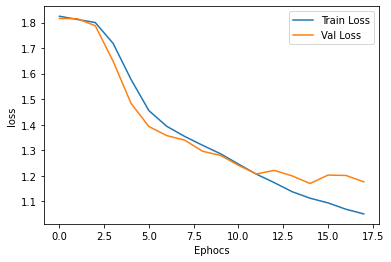

In [20]:
plt.plot(trained_model_conv.history['loss'],label='Train Loss')
plt.plot(trained_model_conv.history['val_loss'],label='Val Loss')
plt.xlabel('Ephocs')
plt.ylabel('loss')
plt.legend()
plt.show()

Driver Code

Now i’ll explain the code for Emotion Detection using the model that i created in the above section.

Now we have the engine and the only thing left to make is the body so that our software is complete.

First let’s once more import some modules that are need to run the code.

In [8]:
import tensorflow.keras as keras
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np


Now let’s load the model and also load a classifier that i have used to detect the face of a person in-front of the camera. 
I have used the haarcascade_frontalface_default classifier. Haar Cascade is a machine learning object detection algorithm used to identify objects in an image or video and based on the concept of​​ features proposed by Paul Viola and Michael Jones in their paper “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001. 
The haarcascade_frontalface_default classifier detects the front face of a person in an image or a continuous video feed.

In [ ]:
face_classifier=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#cascadePath = "haarcascade_frontalface_default.xml"
classifier = keras.models.load_model('EmotionDetectionModel.h5')

Now i’ll define a variable class_labels to store the name of the classes or the types of emotions we are going to predict

and also a variable cap to store the value returned by the cv2.VideoCapture method. 

Here the value 0 in VideoCapture is used to instruct the method to use the primary webcam of a laptop.

In [ ]:
class_labels=['Angry','Happy','Neutral','Sad','Surprise']
cap=cv2.VideoCapture(0)


Now i’ll explain the code to make boxes around the faces detected by the classifier in the camera feed.


In [ ]:
while True:
    ret,frame=cap.read()
    labels=[]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray=gray[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi=roi_gray.astype('float')/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)

            preds=classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position=(x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,20),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()